In [4]:
from dotenv import load_dotenv
load_dotenv()
from datasets import load_dataset
import huggingface_hub
import os
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns

# Only for Jannine (pls leave #)
# import datasets
# datasets.config.HF_DATASETS_CACHE = 'C:/Users/janni/huggingface_cache'

nltk.download('punkt_tab')

# Set the directory to download NLTK data
# nltk.data.path.append('C:/Users/janni/nltk_data')

# # Download necessary NLTK data into the specified folder
# nltk.download('punkt', download_dir='C:/Users/janni/nltk_data')
# nltk.download('stopwords', download_dir='C:/Users/janni/nltk_data')

# Download the NLTK 'punkt' tokenizer model
nltk.download('punkt')

huggingface_username = 'HSLU-AICOMP-LearningAgencyLab'
competition = 'learning-agency-lab-automated-essay-scoring-2'

huggingface_hub.login(token=os.getenv('HUGGINGFACE_TOKEN'))

# Load dataset
train = load_dataset(f"{huggingface_username}/{competition}", split="train")
test = load_dataset(f"{huggingface_username}/{competition}", split="test")

train[0]

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\janni/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package punkt to C:\Users\janni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\janni\.cache\huggingface\token
Login successful


Using the latest cached version of the dataset since HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\janni\.cache\huggingface\datasets\HSLU-AICOMP-LearningAgencyLab___learning-agency-lab-automated-essay-scoring-2\default\0.0.0\591bbcdd29176fa5fc1718552ca8a96b22cff322 (last modified on Wed Oct  9 18:06:10 2024).


{'essay_id': '000d118',
 'full_text': 'Many people have car where they live. The thing they don\'t know is that when you use a car alot of thing can happen\xa0like you can get in accidet or\xa0the smoke that the car has is bad to breath\xa0on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban\'s families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden\xa0on the outskirts of freiburd that near the French and Swiss borders. You probaly won\'t see a car in Vauban\'s streets because they are completely "car free" but\xa0If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growin

In [5]:
# Convert dataset to pandas DataFrame
train_df = pd.DataFrame(train)

# Define stopwords and convert to list
stop_words = list(set(stopwords.words('english')))

# Function to clean and tokenize text
def tokenize_text(texts, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    return X, vectorizer.get_feature_names_out()

# Function to get top n n-grams
def get_top_ngrams(texts, ngram_range=(1, 1), n=20):
    X, features = tokenize_text(texts, ngram_range=ngram_range)
    counts = X.sum(axis=0).A1
    ngrams_freq = dict(zip(features, counts))
    return Counter(ngrams_freq).most_common(n)

# Split the dataset into high- and low-scoring essays
high_score_threshold = 4
low_score_threshold = 2
high_scoring_essays = train_df[train_df['score'] >= high_score_threshold]['full_text']
low_scoring_essays = train_df[train_df['score'] <= low_score_threshold]['full_text']

# Get top 20 n-grams for high- and low-scoring essays
top_unigrams_high = get_top_ngrams(high_scoring_essays, ngram_range=(1, 1), n=20)
top_unigrams_low = get_top_ngrams(low_scoring_essays, ngram_range=(1, 1), n=20)

# Plot Word Cloud for High-Scoring Unigrams
def plot_wordcloud(ngrams, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(ngrams))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Bar plot of top n-grams
def plot_bar(ngrams, title):
    ngrams = dict(ngrams)
    plt.figure(figsize=(10, 5))
    plt.bar(ngrams.keys(), ngrams.values())
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

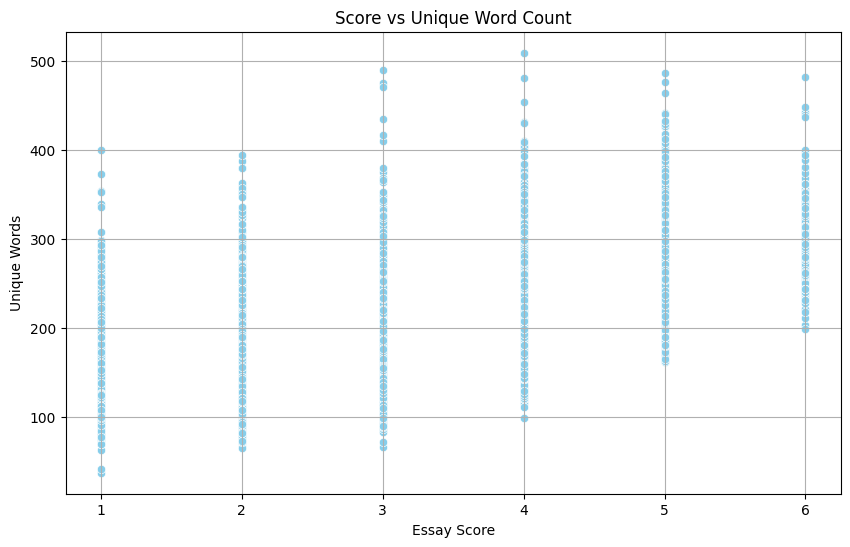

Correlation between score and unique_word_count: 0.62


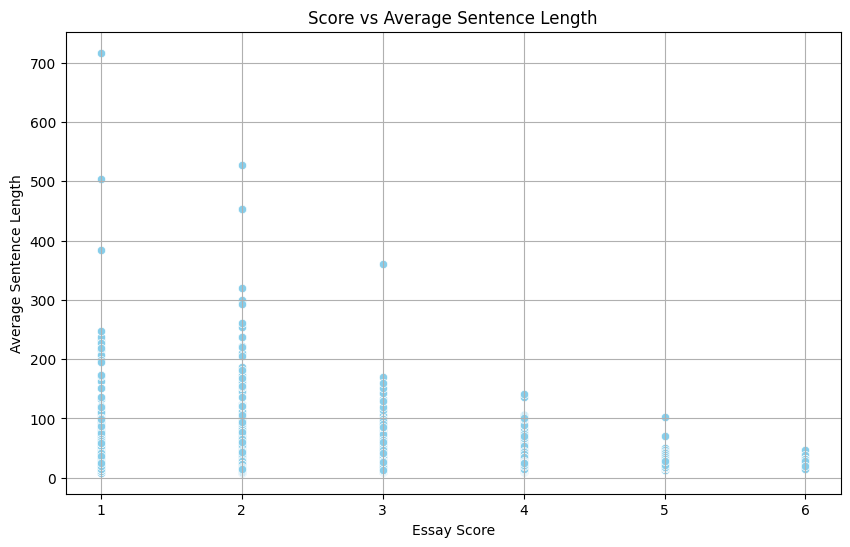

Correlation between score and avg_sentence_length: -0.08


In [6]:
# Function to calculate unique word count
def calculate_unique_words(text):
    words = word_tokenize(text.lower())
    unique_words = set(words)
    return len(unique_words)

# Function to calculate average sentence length
def calculate_avg_sentence_length(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    if len(sentences) == 0:
        return 0
    return len(words) / len(sentences)

# Apply functions to calculate unique word count and avg sentence length for each essay
train_df['unique_word_count'] = train_df['full_text'].apply(calculate_unique_words)
train_df['avg_sentence_length'] = train_df['full_text'].apply(calculate_avg_sentence_length)

# Function to create scatter plots and calculate correlation
def plot_scatter_with_correlation(data, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y=y_col, data=data, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    
    correlation = data[[x_col, y_col]].corr().iloc[0, 1]
    print(f'Correlation between {x_col} and {y_col}: {correlation:.2f}')

# Scatter plot for unique word count vs score
plot_scatter_with_correlation(train_df, 'score', 'unique_word_count', 'Score vs Unique Word Count', 'Essay Score', 'Unique Words')

# Scatter plot for average sentence length vs score
plot_scatter_with_correlation(train_df, 'score', 'avg_sentence_length', 'Score vs Average Sentence Length', 'Essay Score', 'Average Sentence Length')

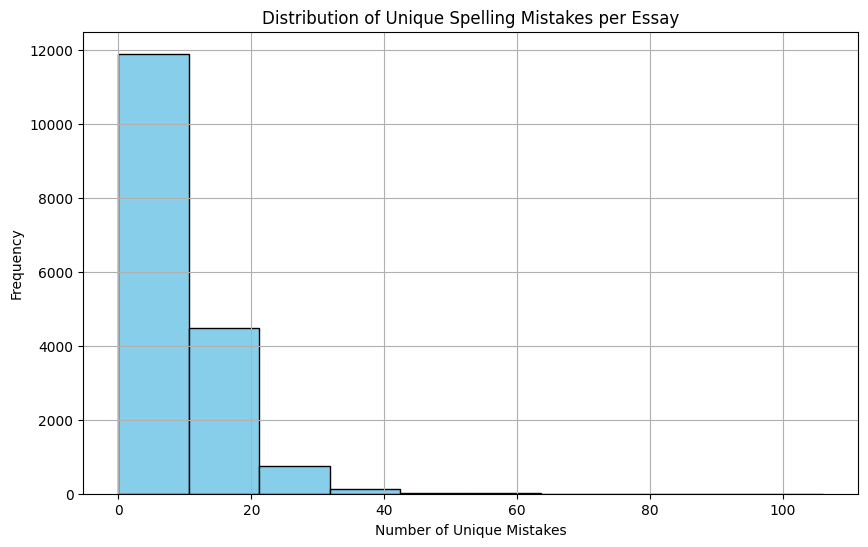

C:\Users\janni\AppData\Local\Temp\ipykernel_20196\214476399.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=df, palette='viridis')


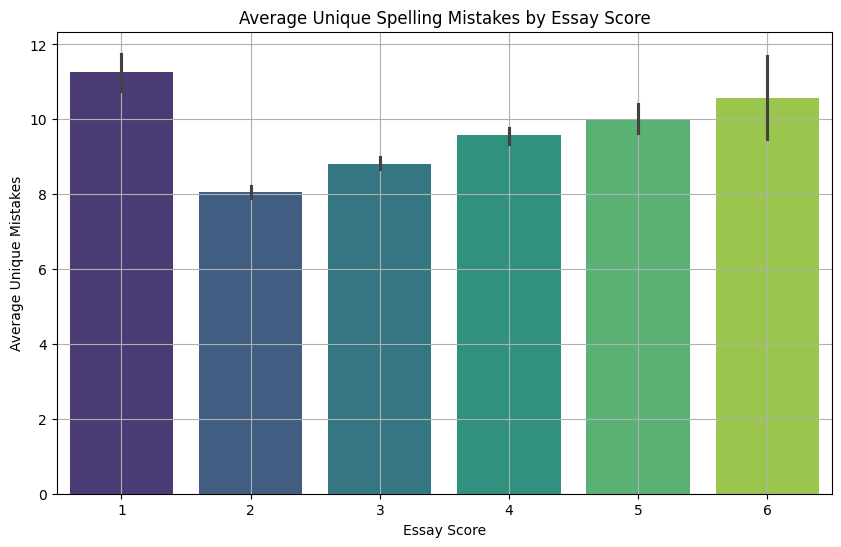

Correlation between unique_mistakes and score: 0.03


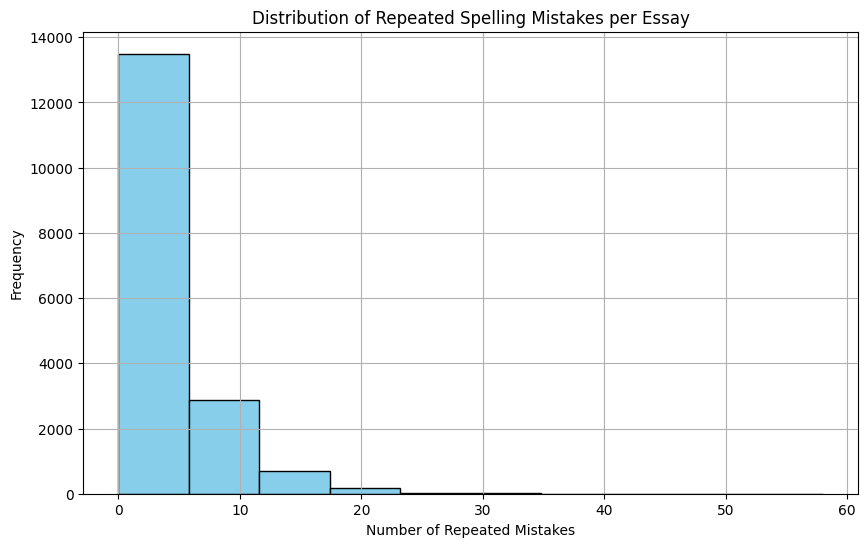

C:\Users\janni\AppData\Local\Temp\ipykernel_20196\214476399.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=df, palette='viridis')


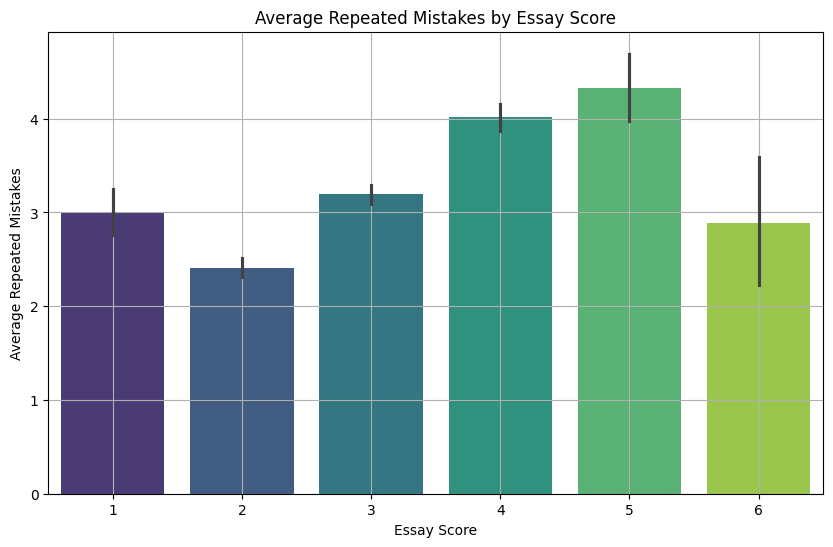

Correlation between repeated_mistakes_count and score: 0.12


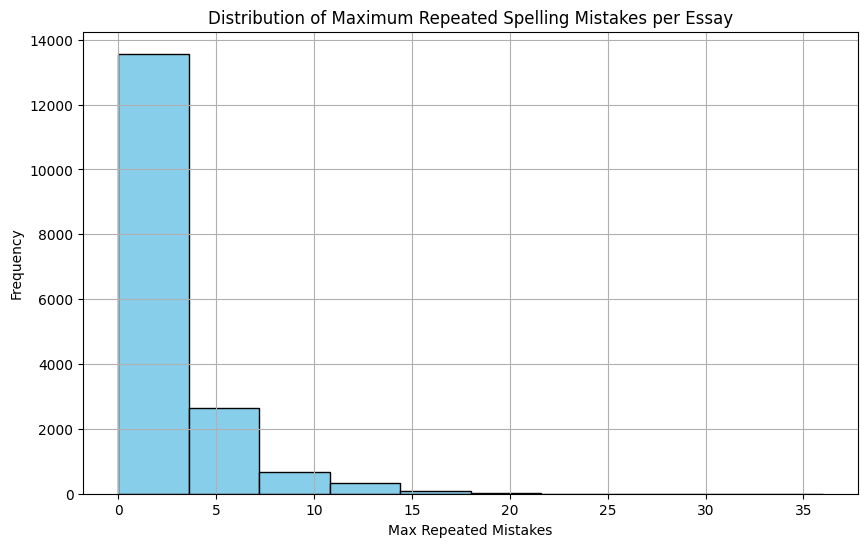

C:\Users\janni\AppData\Local\Temp\ipykernel_20196\214476399.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=df, palette='viridis')


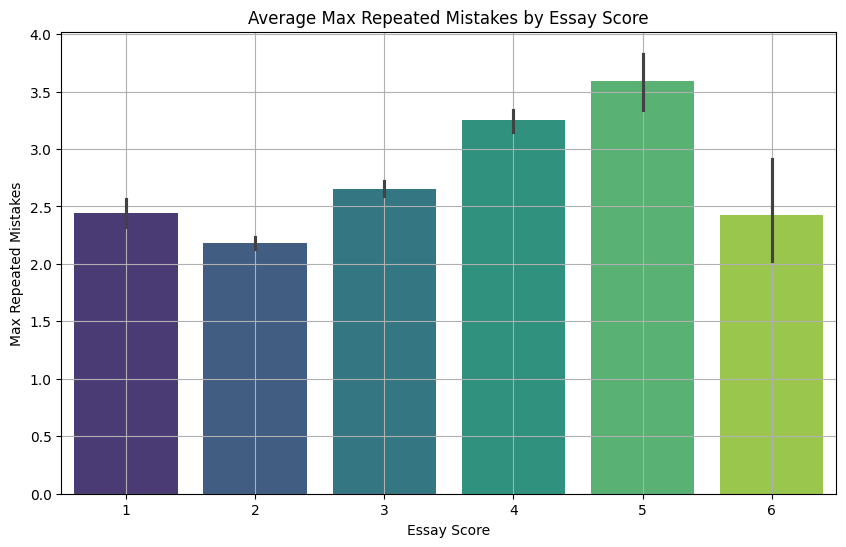

Correlation between max_repeated_mistake and score: 0.14


np.float64(0.14122944205404955)

In [7]:
# Function to create a histogram
def plot_histogram(df, column, title, xlabel, ylabel, bins=10):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=bins, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Function to create a bar plot
def plot_barplot(df, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=df, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Function to calculate and display correlation
def calculate_correlation(df, feature, target='score'):
    correlation = df[[feature, target]].corr().iloc[0, 1]
    print(f'Correlation between {feature} and {target}: {correlation:.2f}')
    return correlation

# Plot for 'unique_mistakes'
plot_histogram(train_df, 'unique_mistakes', 'Distribution of Unique Spelling Mistakes per Essay', 'Number of Unique Mistakes', 'Frequency')
plot_barplot(train_df, 'score', 'unique_mistakes', 'Average Unique Spelling Mistakes by Essay Score', 'Essay Score', 'Average Unique Mistakes')
calculate_correlation(train_df, 'unique_mistakes')

# Plot for 'repeated_mistakes_count'
plot_histogram(train_df, 'repeated_mistakes_count', 'Distribution of Repeated Spelling Mistakes per Essay', 'Number of Repeated Mistakes', 'Frequency')
plot_barplot(train_df, 'score', 'repeated_mistakes_count', 'Average Repeated Mistakes by Essay Score', 'Essay Score', 'Average Repeated Mistakes')
calculate_correlation(train_df, 'repeated_mistakes_count')

# Plot for 'max_repeated_mistake'
plot_histogram(train_df, 'max_repeated_mistake', 'Distribution of Maximum Repeated Spelling Mistakes per Essay', 'Max Repeated Mistakes', 'Frequency')
plot_barplot(train_df, 'score', 'max_repeated_mistake', 'Average Max Repeated Mistakes by Essay Score', 'Essay Score', 'Max Repeated Mistakes')
calculate_correlation(train_df, 'max_repeated_mistake')